In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Jiang

In [ ]:
rlz = pd.read_pickle('data/RLz_jan9b_reruns.pkl')
# nef = pd.read_pickle('data/NEF_RL_jan9b_reruns.pkl')
human = pd.read_pickle("data/jiang.pkl")
neurons = [50,100,200,300,400,500]

columns = ['type', 'neurons', 'sid', 'trial', 'stage', 'neighbors', 'is_greedy', 'noise_driven']
dfs = []
sids = human['sid'].unique()
for sid in sids:
    print(sid)
    trials = human.query("sid==@sid")['trial'].unique()
    for n in neurons:
        nef = pd.read_pickle(f'data/NEF_RL_jiang_{n}neurons_dynamics.pkl')
        for trial in trials:
            neighbors = len(human.query("sid==@sid & trial==@trial & stage==1")['who'].unique())
            stages = human.query("sid==@sid & trial==@trial")['stage'].unique()
            for stage in stages:
                action_rl = rlz.query("sid==@sid & trial==@trial & stage==@stage")['action'].unique()[0]
                action_human = human.query("sid==@sid & trial==@trial & stage==@stage")['action'].unique()[0]
                action_nef = nef.query("sid==@sid & trial==@trial & stage==@stage")['action'].unique()[0]
                expectation_rl = rlz.query("sid==@sid & trial==@trial & stage==@stage")['expectation'].to_numpy()[-1]
                expectation_nef = nef.query("sid==@sid & trial==@trial & stage==@stage")['expectation'].to_numpy()[-1]
                sign_rl = 1 if expectation_rl > 0 else -1
                sign_nef = 1 if expectation_nef > 0 else -1
                is_greedy = True if action_human==sign_rl else False
                noise_driven = True if sign_nef!=sign_rl else False
                dfs.append(pd.DataFrame([["NEF_RL", n, sid, trial, stage, neighbors, is_greedy, noise_driven]], columns=columns))
noise_driven_data = pd.concat(dfs, ignore_index=True)

In [3]:
# noise_driven_data.to_pickle("data/noise_driven_data.pkl")
noise_driven_data = pd.read_pickle("data/noise_driven_data.pkl")

In [ ]:
dfs = []
columns = ['type', 'neurons', 'sid', 'is_greedy', 'noise_driven', "sample size"]
for sid in sids:
    for neurons in noise_driven_data['neurons'].unique():
        greedy_subdata = noise_driven_data.query("sid==@sid & neurons==@neurons & is_greedy==True")
        nongreedy_subdata = noise_driven_data.query("sid==@sid & neurons==@neurons & is_greedy==False")
        greedy_noisy = greedy_subdata.query("noise_driven==True").size
        greedy_choicy = greedy_subdata.query("noise_driven==False").size
        greedy_sample_size = greedy_noisy + greedy_choicy
        greedy_fraction = greedy_noisy / greedy_sample_size
        nongreedy_noisy = nongreedy_subdata.query("noise_driven==True").size
        nongreedy_choicy = nongreedy_subdata.query("noise_driven==False").size
        nongreedy_sample_size = nongreedy_noisy + nongreedy_choicy
        nongreedy_fraction = nongreedy_noisy / nongreedy_sample_size
        dfs.append(pd.DataFrame([["NEF_RL", neurons, sid, True, greedy_fraction, greedy_sample_size]], columns=columns))
        dfs.append(pd.DataFrame([["NEF_RL", neurons, sid, False, nongreedy_fraction, nongreedy_sample_size]], columns=columns))
noise_data_fraction = pd.concat(dfs, ignore_index=True)

In [4]:
# noise_data_fraction.to_pickle("data/noisy_data_fraction.pkl")
noise_data_fraction = pd.read_pickle("data/noisy_data_fraction.pkl")

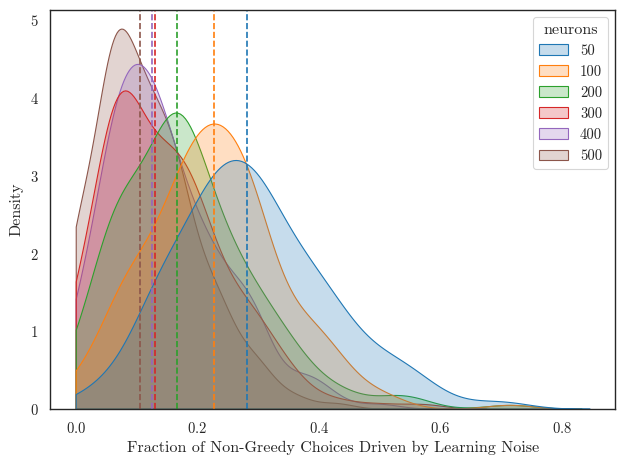

In [14]:
fig, ax = plt.subplots()
sns.kdeplot(noise_data_fraction.query("is_greedy==False"), x='noise_driven', hue='neurons',
            palette=palette[:6], common_norm=False, fill=True, clip=[0,1])
for n, neurons in enumerate(noise_data_fraction['neurons'].unique()):
    median = noise_data_fraction.query("is_greedy==False & neurons==@neurons")['noise_driven'].median()
    ax.axvline(median, color=palette[n], ls="--")
ax.set(xlabel="Fraction of Non-Greedy Choices Driven by Learning Noise")
plt.tight_layout()
fig.savefig("plots/NEF_RL_learning_noise_vs_neurons_jiang.jpg", dpi=600)

## Performance (human fit) of NEF_RL vs RLz for different n_neurons (Jiang)

In [9]:
rlz = pd.read_pickle('data/RLz_jan9b_performance.pkl')
nef50 = pd.read_pickle(f'data/NEF_RL_jiang_{50}neurons_performance.pkl')
nef100 = pd.read_pickle(f'data/NEF_RL_jiang_{100}neurons_performance.pkl')
nef200 = pd.read_pickle(f'data/NEF_RL_jiang_{200}neurons_performance.pkl')
nef300 = pd.read_pickle(f'data/NEF_RL_jiang_{300}neurons_performance.pkl')
nef400 = pd.read_pickle(f'data/NEF_RL_jiang_{400}neurons_performance.pkl')
nef500 = pd.read_pickle(f'data/NEF_RL_jiang_{500}neurons_performance.pkl')
nef1000 = pd.read_pickle(f'data/NEF_RL_jiang_{1000}neurons_performance.pkl')
rlz['neurons'] = 0
nef50['neurons'] = 50
nef100['neurons'] = 100
nef200['neurons'] = 200
nef300['neurons'] = 300
nef400['neurons'] = 400
nef500['neurons'] = 500
nef1000['neurons'] = 1000

nef_rlz_performance = pd.concat([rlz, nef50, nef100, nef200, nef300, nef400, nef500, nef1000], ignore_index=True)

In [15]:
best_fit_dict = {'50': 0, '100': 0, '200': 0, '300': 0, '400': 0, '500': 0, '1000': 0, '0': 0}
n_sids = len(nef_rlz_performance['sid'].unique())
for sid in nef_rlz_performance['sid'].unique():
    # R2s = nef_rlz_performance.query("sid==@sid")['McFadden R2'].to_numpy()
    NLLs = nef_rlz_performance.query("sid==@sid")['NLL'].to_numpy()
    neurons = nef_rlz_performance.query("sid==@sid")['neurons'].to_numpy()
    # idx = np.argmax(R2s)
    idx = np.argmin(NLLs)
    best_model = neurons[idx]
    best_fit_dict[str(best_model)] += 1/n_sids
dfs = []
columns = ['type', 'best fit to human data']
for key, value in best_fit_dict.items():
    name = 'RLz' if key=='0' else f'NEF.RL ({key})'
    dfs.append(pd.DataFrame([[name, value]], columns=columns))
best_fit_data = pd.concat(dfs, ignore_index=True)

/tmp/ipykernel_11648/1351146571.py:2: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.barplot(best_fit_data, x='type', y='best fit to human data', hue='type', ax=ax, palette=palette)


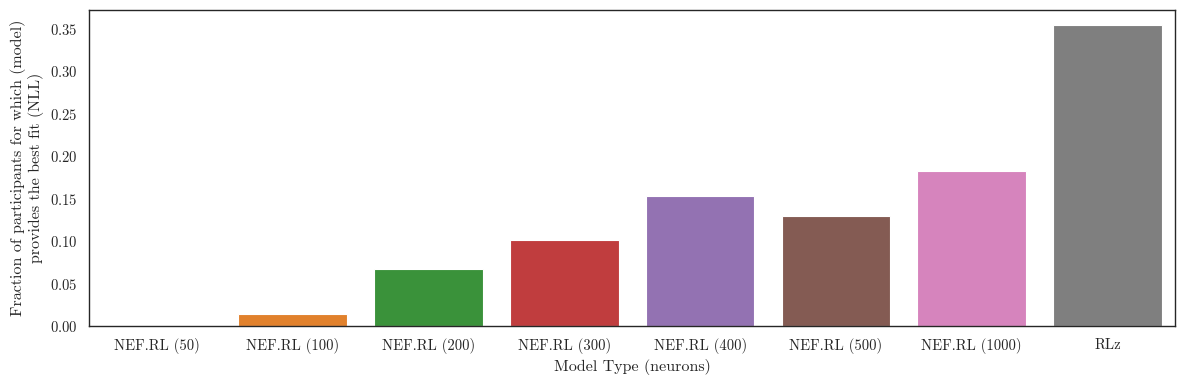

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(best_fit_data, x='type', y='best fit to human data', hue='type', ax=ax, palette=palette)
ax.set(xlabel='Model Type (neurons)', ylabel='Fraction of participants for which (model)\nprovides the best fit (NLL)')
plt.tight_layout()
fig.savefig("plots/rls_best_fit_vs_neurons_jiang.jpg", dpi=600)

## Performance (human fit) of NEF_RL vs RL for different n_neurons (Carrabin)

In [ ]:
rlz = pd.read_pickle('data/RLz_jan9b_performance.pkl')
nef50 = pd.read_pickle(f'data/NEF_RL_jiang_{50}neurons_performance.pkl')
nef100 = pd.read_pickle(f'data/NEF_RL_jiang_{100}neurons_performance.pkl')
nef200 = pd.read_pickle(f'data/NEF_RL_jiang_{200}neurons_performance.pkl')
nef300 = pd.read_pickle(f'data/NEF_RL_jiang_{300}neurons_performance.pkl')
nef400 = pd.read_pickle(f'data/NEF_RL_jiang_{400}neurons_performance.pkl')
nef500 = pd.read_pickle(f'data/NEF_RL_jiang_{500}neurons_performance.pkl')
nef1000 = pd.read_pickle(f'data/NEF_RL_jiang_{1000}neurons_performance.pkl')
rlz['neurons'] = 0
nef50['neurons'] = 50
nef100['neurons'] = 100
nef200['neurons'] = 200
nef300['neurons'] = 300
nef400['neurons'] = 400
nef500['neurons'] = 500
nef1000['neurons'] = 1000

nef_rlz_performance = pd.concat([rlz, nef50, nef100, nef200, nef300, nef400, nef500, nef1000], ignore_index=True)